In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
DATA_DIR = './'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

PLOTS_DIR = f'{DATA_DIR}/plots'

OUTPUT_DIR = f'{DATA_DIR}/output'
MODEL_CHECKPOINT_DIR = f'{DATA_DIR}/models'

## Base Models

### Preprocessing

In [3]:
import pandas as pd
import numpy as np


train = pd.read_csv(f'{TRAIN_DIR}/Train.csv')
desc = pd.read_csv(f'{DATA_DIR}/DataDictionary.csv')

In [4]:

CAT = desc[36:]['Column Name'].tolist()
train_df = train.drop(columns=CAT)

In [5]:
from fossil.preprocessing import FossilPreprocessor, LabelEncoder
from fossil.config import ModelsConfig

np.random.seed(ModelsConfig.SEED)
sku_encoder = LabelEncoder(train.sku_name.sample(frac=0.95, random_state=ModelsConfig.SEED).unique())

fossil_preproc = FossilPreprocessor(sku_encoder)

In [6]:
base_data = fossil_preproc.prepare_primary_data(train_df)

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

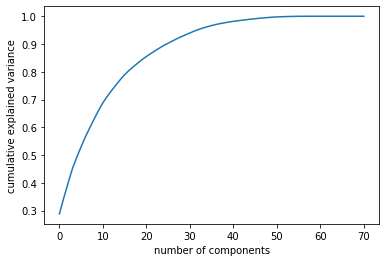

In [7]:
fossil_preproc.pca_feature_selection(base_data, eda=True)

In [8]:
principal_features = fossil_preproc.pca_feature_selection(base_data, 50)

### Training

In [17]:
from fossil.models.gbdt import FossilGBDT

In [18]:
gbdt_models = FossilGBDT()

In [19]:
cols = principal_features+['sku_name','sku_coded', 'month', 'year']
feature_cols = [c for c in base_data.columns if c in cols]
target_cols = [c for c in base_data.columns if 'target' in c]

In [20]:

primary_cv_models = gbdt_models.train_model(base_data, feature_cols, target_cols, True, 
                                         True, False, model_type='lgb')

Training model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[239]	training's l1: 113999	valid_1's l1: 155863


Training fold 2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[675]	training's l1: 79765	valid_1's l1: 117185


Training fold 3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[673]	training's l1: 78092.4	valid_1's l1: 127827
Elapsed 0.10 mins
--------------------------------------------------


Training model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[629]	training's l1: 77315.8	valid_1's l1: 148814


Training fold 2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[650]	training's l1: 78336.7	valid_1's l1: 133285


Training fold 3
Training until 

In [13]:
primary_val_mae, primary_oof = gbdt_models.test_model(base_data, feature_cols, target_cols, 
                                                      primary_cv_models, True, True)

Making timestep 1 predictions
Val MAE: 133795.3755917538


Making timestep 2 predictions
Val MAE: 136597.2491148936


Making timestep 3 predictions
Val MAE: 130142.7268334461


Making timestep 4 predictions
Val MAE: 126529.39100255941


Average Val MAE: 131766.1856356564


In [14]:
target_cols = [f'target_{i}' for i in range(ModelsConfig.N_STEPS)]
pred_cols = [f'preds_{i}' for i in range(ModelsConfig.N_STEPS)]

secondary_data = fossil_preproc.prepare_secondary_data(base_data, primary_oof, target_cols, pred_cols)

In [15]:
cols = ['sku_name','sku_coded','preds', 'time_step', 'month', 'year']
secondary_features = [c for c in secondary_data.columns if 'lag' in c or c in cols]
secondary_targets = 'target'

secondary_cv_models = gbdt_models.train_model(secondary_data, secondary_features, secondary_targets, False, False,
                                              False, ModelsConfig.META_LEARNER,  'meta')



Training fold 1
0:	learn: 205319.0253969	test: 205319.0253969	test1: 223763.1098528	best: 223763.1098528 (0)	total: 75.4ms	remaining: 12m 34s
500:	learn: 114058.8878551	test: 114058.8878551	test1: 130250.3634474	best: 130250.3634474 (500)	total: 3.93s	remaining: 1m 14s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 129186.5
bestIteration = 753

Shrink model to first 754 iterations.
Elapsed 0.13 mins
--------------------------------------------------




Training fold 2
0:	learn: 209814.7152313	test: 209814.7152313	test1: 214766.9149703	best: 214766.9149703 (0)	total: 8.12ms	remaining: 1m 21s
500:	learn: 118838.0963947	test: 118838.0963947	test1: 118788.1659704	best: 118788.1659704 (500)	total: 3.95s	remaining: 1m 14s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 117848.3308
bestIteration = 748

Shrink model to first 749 iterations.
Elapsed 0.26 mins
--------------------------------------------------




Training fold 3
0:	learn: 219292.0251461	t

In [16]:
secondary_val_mae, secondary_oof = gbdt_models.test_model(secondary_data, secondary_features, secondary_targets,
                                      secondary_cv_models, False, False)



Making fold 1 predictions
Val MAE: 129186.49995364537




Making fold 2 predictions
Val MAE: 117848.33075800075




Making fold 3 predictions
Val MAE: 111781.29247147623


Average Val MAE: 119676.25688484599


## Meta Model

### Data Prep

## Inference

In [21]:

test = pd.read_csv(f'{TEST_DIR}/Test.csv')
train = pd.read_csv(f'{TRAIN_DIR}/Train.csv')
desc = pd.read_csv(f'{DATA_DIR}/DataDictionary.csv')

CAT = desc[36:]['Column Name'].tolist()
train_df = train.drop(columns=CAT)

In [22]:
from fossil.inference import prepare_test_context, prepare_submission_data, prepare_test_dates
from fossil.config import ModelsConfig
from fossil.preprocessing import FossilData, LabelEncoder

np.random.seed(ModelsConfig.SEED)
sku_encoder = LabelEncoder(train.sku_name.sample(frac=0.95).unique())


fossil_preproc = FossilPreprocessor(sku_encoder)
test_context, test_dates = prepare_test_context(train_df, test, fossil_preproc)

In [23]:
feature_cols = [c for c in test_context.columns if c not in ['sku_name', 'month', 'year']
             and all(l not in c for l in ['target', 'channel','rel'])]

test_data = fossil_preproc.prepare_primary_data(test_context, True)

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [24]:
test_data = test_data[test_data[['month', 'year']].apply(tuple, axis=1).isin(test_dates)]

In [25]:
target_cols = [f'target_{i}' for i in range(ModelsConfig.N_STEPS)]
pred_cols = [f'preds_{i}' for i in range(ModelsConfig.N_STEPS)]

cols = principal_features+['month','year']
non_features = ['sku_name','sku_coded']+target_cols
feature_cols = [c for c in test_data.columns if c not in non_features and c in cols]

In [26]:
from fossil.models.gbdt import FossilGBDT
gbdt_models = FossilGBDT()

primary_preds = gbdt_models.forecast(test_data, feature_cols, target_cols, primary_cv_models, True, True, True)

In [27]:
sub_df = prepare_submission_data(test, primary_preds, target_cols, pred_cols)
# sub_df = fossil_preproc.adjust_expanded_dates(sub_df)

In [28]:
# secondary_test = fossil_preproc.prepare_secondary_data(test_data, primary_preds[target_cols], target_cols, pred_cols)

In [29]:
_, pred_dates = prepare_test_dates(test) 

sub_df['month'] = pd.DataFrame(pred_dates*int(len(sub_df)/ModelsConfig.N_STEPS)).loc[:, 0].values
sub_df['year'] = pd.DataFrame(pred_dates*int(len(sub_df)/ModelsConfig.N_STEPS)).loc[:, 1].values

In [30]:
cols = ['preds', 'time_step', 'month', 'year', 'pred_month', 'pred_year']
meta_features = [c for c in sub_df.columns if 'lag' in c or c in cols]
meta_targets = 'Target'

sub_df = gbdt_models.forecast(sub_df, meta_features, meta_targets, secondary_cv_models, True, False, False)

In [31]:

sub_df['Item_ID'] = sub_df['sku_name'].astype(str)+'_'+sub_df['month'].astype(int).astype(str)+'_'+sub_df['year'].astype(int).astype(str)

In [32]:
save_name = f'{OUTPUT_DIR}/fossil_{ModelsConfig.BASE_MODEL}_{ModelsConfig.META_LEARNER}_{secondary_val_mae}.csv'
sub_df[['Item_ID','Target']].to_csv(save_name, index=False)

In [33]:
# save_name = f'{OUTPUT_DIR}/fossil_{ModelsConfig.BASE_MODEL}_{ModelsConfig.META_LEARNER}_{metrics_list[-1]}_cnnpred.csv'
# sub_df[['Item_ID','Target']].to_csv(save_name, index=False)

In [34]:
sub_df#[['month','year','pred_month','pred_year']]

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,onhand_inventory_9month_MM,leftover_inventory_6month_MM,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded,preds,time_step,Target,Item_ID
0,ABEAHAMASHL,11,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,68493.186385,0,18653.989835,ABEAHAMASHL_11_2021
1,ABEAHAMASHL,12,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,139666.726152,1,44493.463182,ABEAHAMASHL_12_2021
2,ABEAHAMASHL,1,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,125585.440628,2,57307.201628,ABEAHAMASHL_1_2022
3,ABEAHAMASHL,2,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,123148.299105,3,47657.033155,ABEAHAMASHL_2_2022
4,ABEENNEARMAZZ,11,2021,42546.0,152963.0,58754.0,35455.0,0.0,0.0,0.0,...,600709.0,68884.0,106365.0,129.0,129.0,633.0,262311.050127,0,154738.264677,ABEENNEARMAZZ_11_2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,YOSHRENECARL,2,2022,1527604.0,288705.0,199561.0,79014.0,0.0,0.0,0.0,...,793179.0,211717.0,214756.0,129.0,129.0,248.0,304326.984856,3,191719.104550,YOSHRENECARL_2_2022
1524,YOSHTLYNYOSHZZ,11,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,244010.740011,0,132271.452093,YOSHTLYNYOSHZZ_11_2021
1525,YOSHTLYNYOSHZZ,12,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,267407.530586,1,172168.502814,YOSHTLYNYOSHZZ_12_2021
1526,YOSHTLYNYOSHZZ,1,2022,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,221509.683499,2,121917.254334,YOSHTLYNYOSHZZ_1_2022


In [69]:
sub_df#[['month','year','pred_month','pred_year']]

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,onhand_inventory_9month_MM,leftover_inventory_6month_MM,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded,preds,time_step,Target,Item_ID
0,ABEAHAMASHL,11,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,68493.186385,0,18653.989835,ABEAHAMASHL_11_2021
1,ABEAHAMASHL,12,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,139666.726152,1,44493.463182,ABEAHAMASHL_12_2021
2,ABEAHAMASHL,1,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,125585.440628,2,57307.201628,ABEAHAMASHL_1_2022
3,ABEAHAMASHL,2,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,123148.299105,3,47657.033155,ABEAHAMASHL_2_2022
4,ABEENNEARMAZZ,11,2021,42546.0,152963.0,58754.0,35455.0,0.0,0.0,0.0,...,600709.0,68884.0,106365.0,129.0,129.0,633.0,262311.050127,0,154738.264677,ABEENNEARMAZZ_11_2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,YOSHRENECARL,2,2022,1527604.0,288705.0,199561.0,79014.0,0.0,0.0,0.0,...,793179.0,211717.0,214756.0,129.0,129.0,248.0,304326.984856,3,191719.104550,YOSHRENECARL_2_2022
1524,YOSHTLYNYOSHZZ,11,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,244010.740011,0,132271.452093,YOSHTLYNYOSHZZ_11_2021
1525,YOSHTLYNYOSHZZ,12,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,267407.530586,1,172168.502814,YOSHTLYNYOSHZZ_12_2021
1526,YOSHTLYNYOSHZZ,1,2022,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,221509.683499,2,121917.254334,YOSHTLYNYOSHZZ_1_2022


In [107]:
sub_df#[['month','year','pred_month','pred_year']]

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,onhand_inventory_9month_MM,leftover_inventory_6month_MM,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded,preds,time_step,Target,Item_ID
0,ABEAHAMASHL,11,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,68493.186385,0,18653.989835,ABEAHAMASHL_11_2021
1,ABEAHAMASHL,12,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,139666.726152,1,44493.463182,ABEAHAMASHL_12_2021
2,ABEAHAMASHL,1,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,125585.440628,2,57307.201628,ABEAHAMASHL_1_2022
3,ABEAHAMASHL,2,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,123148.299105,3,47657.033155,ABEAHAMASHL_2_2022
4,ABEENNEARMAZZ,11,2021,42546.0,152963.0,58754.0,35455.0,0.0,0.0,0.0,...,600709.0,68884.0,106365.0,129.0,129.0,633.0,262311.050127,0,154738.264677,ABEENNEARMAZZ_11_2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,YOSHRENECARL,2,2022,1527604.0,288705.0,199561.0,79014.0,0.0,0.0,0.0,...,793179.0,211717.0,214756.0,129.0,129.0,248.0,304326.984856,3,191719.104550,YOSHRENECARL_2_2022
1524,YOSHTLYNYOSHZZ,11,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,244010.740011,0,132271.452093,YOSHTLYNYOSHZZ_11_2021
1525,YOSHTLYNYOSHZZ,12,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,267407.530586,1,172168.502814,YOSHTLYNYOSHZZ_12_2021
1526,YOSHTLYNYOSHZZ,1,2022,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,221509.683499,2,121917.254334,YOSHTLYNYOSHZZ_1_2022


In [31]:
sub_df#[['month','year','pred_month','pred_year']]

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,onhand_inventory_9month_MM,leftover_inventory_6month_MM,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded,preds,time_step,Target,Item_ID
0,ABEAHAMASHL,11,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,68493.186385,0,32036.237317,ABEAHAMASHL_11_2021
1,ABEAHAMASHL,12,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,139666.726152,1,69860.310366,ABEAHAMASHL_12_2021
2,ABEAHAMASHL,1,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,125585.440628,2,68940.364406,ABEAHAMASHL_1_2022
3,ABEAHAMASHL,2,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,123148.299105,3,75302.944389,ABEAHAMASHL_2_2022
4,ABEENNEARMAZZ,11,2021,42546.0,152963.0,58754.0,35455.0,0.0,0.0,0.0,...,600709.0,68884.0,106365.0,129.0,129.0,633.0,262311.050127,0,155138.417735,ABEENNEARMAZZ_11_2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,YOSHRENECARL,2,2022,1527604.0,288705.0,199561.0,79014.0,0.0,0.0,0.0,...,793179.0,211717.0,214756.0,129.0,129.0,248.0,304326.984856,3,225663.606927,YOSHRENECARL_2_2022
1524,YOSHTLYNYOSHZZ,11,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,244010.740011,0,132067.748265,YOSHTLYNYOSHZZ_11_2021
1525,YOSHTLYNYOSHZZ,12,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,267407.530586,1,162292.481192,YOSHTLYNYOSHZZ_12_2021
1526,YOSHTLYNYOSHZZ,1,2022,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,221509.683499,2,129818.557819,YOSHTLYNYOSHZZ_1_2022


In [54]:
secondary_data

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,onhand_inventory_6month_MM,onhand_inventory_9month_MM,leftover_inventory_6month_MM,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded,target,preds,time_step
0,ABEAHAMASHL,5.0,2016.0,6844841.0,902583.0,542968.0,236029.0,34442.0,0.0,14182.0,...,1529123.50,1584332.0,50143.50,56728.0,145.0,145.0,74.0,358602.0,993988.457097,0
1,ABEAHAMASHL,5.0,2016.0,6844841.0,902583.0,542968.0,236029.0,34442.0,0.0,14182.0,...,1529123.50,1584332.0,50143.50,56728.0,145.0,145.0,74.0,1177106.0,963319.364140,1
2,ABEAHAMASHL,5.0,2016.0,6844841.0,902583.0,542968.0,236029.0,34442.0,0.0,14182.0,...,1529123.50,1584332.0,50143.50,56728.0,145.0,145.0,74.0,968428.0,638536.972105,2
3,ABEAHAMASHL,5.0,2016.0,6844841.0,902583.0,542968.0,236029.0,34442.0,0.0,14182.0,...,1529123.50,1584332.0,50143.50,56728.0,145.0,145.0,74.0,470032.0,613783.671361,3
4,ABEANHARLE,5.0,2016.0,0.0,388992.0,321121.0,0.0,38494.0,0.0,0.0,...,1201924.50,1192301.0,-20260.00,10130.0,125.0,125.0,1223.0,154989.0,420339.695346,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172931,YOSHLEENBART,4.0,2021.0,135742.0,152963.0,25325.0,10130.0,66858.0,1013.0,0.0,...,252490.25,251224.0,191963.50,141820.0,129.0,129.0,725.0,237042.0,132547.547953,3
172932,YOSHRENECARL,4.0,2021.0,76988.0,84079.0,0.0,0.0,40520.0,0.0,1013.0,...,823822.25,793179.0,219567.75,214756.0,129.0,129.0,248.0,456863.0,187077.629589,0
172933,YOSHRENECARL,4.0,2021.0,76988.0,84079.0,0.0,0.0,40520.0,0.0,1013.0,...,823822.25,793179.0,219567.75,214756.0,129.0,129.0,248.0,362654.0,255827.652601,1
172934,YOSHRENECARL,4.0,2021.0,76988.0,84079.0,0.0,0.0,40520.0,0.0,1013.0,...,823822.25,793179.0,219567.75,214756.0,129.0,129.0,248.0,241094.0,291710.736521,2


## Misc

In [ ]:
target_cols = [f'target_{i}' for i in range(ModelsConfig.N_STEPS)]
pred_cols = [f'preds_{i}' for i in range(ModelsConfig.N_STEPS)]

for i,oof in enumerate([primary_oof, secondary_oof]):
    meta_base = base_data.copy()
    meta_base[pred_cols] = oof.reshape(-1, ModelsConfig.N_STEPS)
    meta_padded = meta_base.groupby(['month','year']).apply(fossil_preproc.pad_sku_sequence, pad_value=np.nan)
    meta_padded.reset_index(drop=True, inplace=True)


    meta_primary = meta_padded.drop(columns=pred_cols)
    meta_oof = meta_padded[pred_cols].values
    meta_expanded = fossil_preproc.expand_primary_data(meta_primary, meta_oof, target_cols, pred_cols)
    
    if i==0:
        meta_data = meta_expanded.drop(columns=['preds']).copy()
        
    meta_data[f'preds_{i}'] = meta_expanded['preds']

In [ ]:

meta_data['target'] = meta_data.groupby('sku_name')['target'].progress_transform(lambda x: x.fillna(x.median()))
meta_data['target'] = meta_data.groupby(['month','year'])['target'].progress_transform(lambda x: x.fillna(x.median()))

  0%|          | 0/3858 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

In [23]:
meta_data.fillna(0, inplace=True)

meta_dates = sorted([(m, y) for y,m in meta_data.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

In [24]:
from sklearn.preprocessing import MinMaxScaler

meta_features = [c for c in meta_data.columns if 'preds' in c]
meta_targets = 'target'

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_scaler.fit(meta_data[meta_features])
y_scaler.fit(meta_data['target'].values.reshape(-1,1))

meta_data[meta_features] = x_scaler.transform(meta_data[meta_features])
meta_data[meta_targets] = y_scaler.transform(meta_data[meta_targets].values.reshape(-1,1))

In [25]:
meta_data['time_step'] = meta_data.groupby(['sku_name','sku_coded','month','year']).cumcount()

In [26]:
from tqdm.notebook import tqdm
def get_data(
        data:pd.DataFrame, 
        dates:list, 
        feature_cols:list, 
        target_cols:list, 
        validation:bool=False
        ):
    
    data_list = []
    y_test = None
    
    for date in tqdm(dates):
        time_step_data = data[data[['month','year']].apply(tuple, axis=1).isin([date])]
        time_step_avg = time_step_data.groupby(['sku_coded','time_step']).mean().reset_index()
        
        grouped_data = time_step_avg.sort_values(['sku_coded','year','month']).groupby(['sku_coded'])
                
        sequence = np.array([v[feature_cols] for k,v in grouped_data])
        targets = time_step_avg[target_cols].values
        
        if validation:
            y_test = time_step_data[time_step_data['sku_name']!=0]
        data_list.append(((sequence, targets), y_test))
        
    return data_list

In [27]:
meta_features = [c for c in meta_data.columns if 'preds' in c]
meta_targets = 'target'

meta_train = get_data(meta_data, meta_dates[:-1], meta_features, meta_targets)
meta_val = get_data(meta_data, meta_dates[1:], meta_features, meta_targets, True)

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

In [28]:
import torch
from torch.utils.data import DataLoader

from fossil.preprocessing import FossilDataset, collate_fn
from fossil.models.blender import FossilBlender
from fossil.utils.pipeline import FossilPipeline

expanding_window = True
models, metrics_list, loss_list,  = [], [], []
train_set, val_set = [], []

for ix in range(len(meta_dates[:-1])):
    if expanding_window:
        print('Training step {} from {}/{} to {}/{}:'.format(ix+1, meta_dates[0][0], meta_dates[0][1], meta_dates[ix][0], meta_dates[ix][1]))
        print('\n')
        train_set += [meta_train[ix]]    
        val_set += [meta_val[ix]]

    # else:
    #     print('Training step {} from {}/{} to {}/{}:'.format(ix+1, dates[ix-window][0], dates[ix-window][1], dates[ix][0], dates[ix][1]))
    #     print('\n')
    #     train_set = [train_norm[i] for i in range(ix-window,ix)] if ix>window else train_norm[:ix+1]
    #     val_set = [val_norm[i] for i in range(ix-window,ix)] if ix>window else val_norm[:ix+1]
       
    meta_train_set = FossilDataset(train_set)
    meta_val_set = FossilDataset(val_set)

    meta_train_loader = DataLoader(meta_train_set, collate_fn=lambda x: collate_fn(x, len(sku_encoder)), shuffle=False)
    meta_val_loader = DataLoader(meta_val_set, collate_fn=lambda x: collate_fn(x, len(sku_encoder)), shuffle=False)
    # model = pipe.model if ix>0 else FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
    
    model = FossilBlender(len(meta_features), 4, len(sku_encoder)+1, ModelsConfig.N_STEPS).double()
    pipe = FossilPipeline(meta_train_loader, meta_val_loader, model, y_scaler)
    
    torch.manual_seed(ModelsConfig.SEED)
    pipe.train_model(3, 1)
    best_model, val_loss, metrics = pipe.model_checkpoints[-1]
    
    models.append(best_model)
    loss_list.append(val_loss)
    metrics_list.append(metrics)
print('Average Val loss: {:.4f}\tAverage Val MAE: {:.4f}'.format(np.mean(loss_list), np.mean(metrics_list)))
print('-'*50)

Training step 1 from 1.0/2016.0 to 1.0/2016.0:


Epoch 1: Train Loss: 0.1191	Val Loss: 0.3690	Val MAE: 4264309.90	elapsed: 0.02 mins
Epoch 2: Train Loss: 0.3600	Val Loss: 0.1409	Val MAE: 1685420.66	elapsed: 0.02 mins
Epoch 3: Train Loss: 0.1579	Val Loss: 0.1086	Val MAE: 1295376.10	elapsed: 0.02 mins
Epoch 4: Train Loss: 0.1084	Val Loss: 0.1070	Val MAE: 1278222.50	elapsed: 0.02 mins
Epoch 5: Train Loss: 0.1069	Val Loss: 0.1053	Val MAE: 1259055.51	elapsed: 0.02 mins
Epoch 6: Train Loss: 0.1051	Val Loss: 0.1035	Val MAE: 1238796.28	elapsed: 0.02 mins
Epoch 7: Train Loss: 0.1032	Val Loss: 0.1016	Val MAE: 1217961.49	elapsed: 0.02 mins
Epoch 8: Train Loss: 0.1013	Val Loss: 0.0997	Val MAE: 1196713.11	elapsed: 0.02 mins
Epoch 9: Train Loss: 0.0994	Val Loss: 0.0977	Val MAE: 1175399.43	elapsed: 0.02 mins
Epoch 10: Train Loss: 0.0974	Val Loss: 0.0957	Val MAE: 1154044.64	elapsed: 0.02 mins
Epoch 11: Train Loss: 0.0954	Val Loss: 0.0938	Val MAE: 1132702.41	elapsed: 0.02 mins
Epoch 12: Train Loss: 0.0

In [29]:
from fossil.preprocessing import FossilDataset, collate_fn
from torch.utils.data import DataLoader

meta_train_set = FossilDataset(meta_train)
meta_val_set = FossilDataset(meta_val)

meta_train_loader = DataLoader(meta_train_set, collate_fn=lambda x: collate_fn(x, len(sku_encoder)), shuffle=False)
meta_val_loader = DataLoader(meta_val_set, collate_fn=lambda x: collate_fn(x, len(sku_encoder)), shuffle=False)

In [30]:
import torch
from fossil.models.blender import FossilBlender
from fossil.utils.pipeline import FossilPipeline

model = FossilBlender(len(meta_features), 4, len(sku_encoder)+1, ModelsConfig.N_STEPS).double()
pipe = FossilPipeline(meta_train_loader, meta_val_loader, model, y_scaler)

In [31]:
torch.manual_seed(ModelsConfig.SEED)
pipe.train_model(3, 1)

Epoch 1: Train Loss: 0.0271	Val Loss: 0.0254	Val MAE: 337114.90	elapsed: 0.01 mins
Epoch 2: Train Loss: 0.0058	Val Loss: 0.0045	Val MAE: 100048.10	elapsed: 0.01 mins
Epoch 3: Train Loss: 0.0053	Val Loss: 0.0039	Val MAE: 90469.68	elapsed: 0.02 mins
Epoch 4: Train Loss: 0.0053	Val Loss: 0.0039	Val MAE: 89237.33	elapsed: 0.03 mins
Epoch 5: Train Loss: 0.0054	Val Loss: 0.0040	Val MAE: 89337.09	elapsed: 0.03 mins
Epoch 6: Train Loss: 0.0054	Val Loss: 0.0040	Val MAE: 89189.73	elapsed: 0.04 mins
Epoch 7: Train Loss: 0.0055	Val Loss: 0.0041	Val MAE: 89448.32	elapsed: 0.05 mins
Epoch 8: Train Loss: 0.0055	Val Loss: 0.0041	Val MAE: 89061.62	elapsed: 0.06 mins
Epoch 9: Train Loss: 0.0055	Val Loss: 0.0041	Val MAE: 89004.81	elapsed: 0.06 mins
Epoch 10: Train Loss: 0.0055	Val Loss: 0.0041	Val MAE: 88362.44	elapsed: 0.07 mins
Epoch 11: Train Loss: 0.0055	Val Loss: 0.0042	Val MAE: 89442.07	elapsed: 0.08 mins
Epoch 12: Train Loss: 0.0056	Val Loss: 0.0043	Val MAE: 89163.07	elapsed: 0.08 mins
Epoch 13: T

In [46]:
# primary_preds = primary_preds[primary_preds.sku_name.isin(test.sku_name.unique())]

for i, preds in enumerate([primary_preds[target_cols].values, secondary_preds['Target'].values]):
    meta_base = test_data.copy()
    meta_base[pred_cols] = preds.reshape(-1, ModelsConfig.N_STEPS)
    meta_padded = meta_base.groupby(['month','year']).apply(fossil_preproc.pad_sku_sequence, pad_value=np.nan)
    meta_padded.reset_index(drop=True, inplace=True)


    meta_primary = meta_padded.drop(columns=pred_cols)
    meta_oof = meta_padded[pred_cols].values
    meta_expanded = fossil_preproc.expand_primary_data(meta_primary, meta_oof, target_cols, pred_cols)

    if i==0:
        meta_data = meta_expanded.drop(columns=['preds']).copy()

    meta_data[f'preds_{i}'] = meta_expanded['preds']

In [47]:

meta_data['target'] = meta_data.groupby('sku_name')['target'].progress_transform(lambda x: x.fillna(x.median()))
meta_data['target'] = meta_data.groupby(['month','year'])['target'].progress_transform(lambda x: x.fillna(x.median()))

  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
meta_data.fillna(0, inplace=True)

meta_dates = sorted([(m, y) for y,m in meta_data.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

In [ ]:

meta_features = [c for c in meta_data.columns if 'preds' in c]
meta_targets = 'target'

meta_data[meta_features] = x_scaler.transform(meta_data[meta_features])
meta_data[meta_targets] = y_scaler.transform(meta_data[meta_targets].values.reshape(-1,1))

In [50]:
meta_data['time_step'] = meta_data.groupby(['sku_name','sku_coded','month','year']).cumcount()

In [51]:
meta_test = get_data(meta_data, test_dates, meta_features, meta_targets)

  0%|          | 0/1 [00:00<?, ?it/s]

In [52]:
(features, targets), y_test = meta_test[0]

In [54]:
pipe.model.load_state_dict(pipe.model.state_dict())

<All keys matched successfully>

In [55]:
meta_preds = model(torch.as_tensor(features).transpose(0,2).unsqueeze(0).to(ModelsConfig.device))
pred_arr = meta_preds.detach().numpy().reshape(-1, ModelsConfig.N_STEPS)

In [56]:
sub_df = meta_data[meta_data['sku_name']!=0]

In [57]:
sub_df['Target'] = pred_arr[sub_df['sku_coded'].astype(int).values, sub_df['time_step'].values]
sub_df['Target'] = y_scaler.inverse_transform(sub_df['Target'].values.reshape(-1, 1))

/tmp/ipykernel_28561/3396961515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Target'] = pred_arr[sub_df['sku_coded'].astype(int).values, sub_df['time_step'].values]
/tmp/ipykernel_28561/3396961515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Target'] = y_scaler.inverse_transform(sub_df['Target'].values.reshape(-1, 1))


In [64]:
meta_secondary = fossil_preproc.prepare_secondary_data(meta_primary, meta_oof, target_cols, pred_cols)
sub_df['month'], sub_df['year'] = meta_secondary['month'], meta_secondary['year']

/tmp/ipykernel_28561/4129148662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['month'], sub_df['year'] = meta_secondary['month'], meta_secondary['year']


In [67]:
sub_df['target'] = y_scaler.inverse_transform(sub_df['target'].values.reshape(-1, 1));sub_df

/tmp/ipykernel_28561/2410078269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['target'] = y_scaler.inverse_transform(sub_df['target'].values.reshape(-1, 1));sub_df


,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded,target,time_step,preds_0,preds_1,Target,Item_ID
0,ABEAHAMASHL,11.0,2021.0,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,-16208.0,149.0,149.0,74.0,69536.362080,0,0.011278,0.015553,12447.405347,ABEAHAMASHL_11_2021
1,ABEAHAMASHL,12.0,2021.0,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,-16208.0,149.0,149.0,74.0,123358.571244,1,0.019387,0.027411,31869.806485,ABEAHAMASHL_12_2021
2,ABEAHAMASHL,1.0,2022.0,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,-16208.0,149.0,149.0,74.0,100678.584110,2,0.015970,0.017177,32274.814645,ABEAHAMASHL_1_2022
3,ABEAHAMASHL,2.0,2022.0,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,-16208.0,149.0,149.0,74.0,109051.794236,3,0.017231,0.019645,18126.535988,ABEAHAMASHL_2_2022
4,ABEANNAONEIZZ,11.0,2021.0,168158.0,76988.0,0.0,10130.0,0.0,0.0,0.0,...,-9117.0,129.0,129.0,2241.0,61056.682074,0,0.010000,0.012935,-6948.350256,ABEANNAONEIZZ_11_2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2559,YOSHRENECARL,2.0,2022.0,1527604.0,288705.0,199561.0,79014.0,0.0,0.0,0.0,...,214756.0,129.0,129.0,248.0,289041.621090,3,0.044350,0.064525,189049.415290,YOSHRENECARL_2_2022
2560,YOSHTLYNYOSHZZ,11.0,2021.0,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,200574.0,149.0,149.0,1852.0,283174.838744,0,0.043466,0.072075,95887.859734,YOSHTLYNYOSHZZ_11_2021
2561,YOSHTLYNYOSHZZ,12.0,2021.0,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,200574.0,149.0,149.0,1852.0,302929.766945,1,0.046443,0.079573,41056.740146,YOSHTLYNYOSHZZ_12_2021
2562,YOSHTLYNYOSHZZ,1.0,2022.0,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,200574.0,149.0,149.0,1852.0,246794.438821,2,0.037985,0.047513,53121.115963,YOSHTLYNYOSHZZ_1_2022


In [63]:
meta_secondary

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,onhand_inventory_6month_MM,onhand_inventory_9month_MM,leftover_inventory_6month_MM,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded,target,preds,time_step
0,ABEAHAMASHL,10.0,2021.0,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,229444.5,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,69536.362080,43735.480111,0
1,ABEAHAMASHL,10.0,2021.0,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,229444.5,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,123358.571244,77079.006822,1
2,ABEAHAMASHL,10.0,2021.0,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,229444.5,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,100678.584110,48301.075780,2
3,ABEAHAMASHL,10.0,2021.0,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,229444.5,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,109051.794236,55242.775411,3
4,ABEANNAONEIZZ,10.0,2021.0,168158.0,76988.0,0.0,10130.0,0.0,0.0,0.0,...,75468.5,176262.0,-8104.0,-9117.0,129.0,129.0,2241.0,61056.682074,36373.702684,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15363,NaN,10.0,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3839.0,NaN,NaN,12799
15364,NaN,10.0,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3840.0,NaN,NaN,12800
15365,NaN,10.0,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3840.0,NaN,NaN,12801
15366,NaN,10.0,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3840.0,NaN,NaN,12802
